In [72]:
import bigml.api
from pandas import DataFrame
from bigml.api import BigML
import matplotlib.pyplot as plt
import statistics

In [5]:
api = BigML(project='project/5dc023c21efc927c10000414')

In [8]:
source_train = api.create_source('https://oml-data.s3.amazonaws.com/kaggle-give-me-credit-train.csv')
                                 
# On crée un dataset à partir de la source puis on split (Val et Test)

train_full = api.create_dataset(source_train, {"name": "Train Full"})
val_set = api.create_dataset(train_full, {"name": "Train_set", "sample_rate": 0.8, "seed": "my seed"})
test_set = api.create_dataset(train_full, {"name": "Val_set", "sample_rate": 0.8 , "seed": "my seed", "out_of_bag": True})
# creation des listes vides pour contenir l'abscisse (taille du dataset) et l'ordonnée (AUC) pour le modele ensemble et deepnet

In [10]:
x_ensemble = []
y_ensemble = []
x_deepnet = []
y_deepnet = []

for i in range(1,11): # On fait une boucle pour faire varier de 10 à 100 % de lignes du dataset Val_set
   
    # On crée le nouveau dataset de train à partir du dataset de train initial
    train_set = api.create_dataset(val_set, {"name": "Train_Set_" + str(i/10), "sample_rate": i/10, "seed": "my seed"})
    api.ok(val_set)   
   
    # On crée le modèle (ensemble) à partir du train_set
    ensemble = api.create_ensemble(train_set, {"objective_field" : "SeriousDlqin2yrs", "name": "Ensemble_" + str(i/10)})
    api.ok(ensemble)
   
    # On évalue le modèle ensemble (avec le test_set)
    evaluation = api.create_evaluation(ensemble, test_set)
    api.ok(evaluation)
   
    # On crée le modèle (deepnet) à partir du train_set
    deepnet = api.create_deepnet(train_set, {"objective_field" : "SeriousDlqin2yrs", "name": "Deepnet_" + str(i/10)})
    api.ok(deepnet)
   
    # On évalue le modèle deepnet (avec le test_set)
    evaluation_deepnet = api.create_evaluation(deepnet, test_set)
    api.ok(evaluation_deepnet)

    # On stocke dans une liste la valeur de l'axe des abscisses (graph_x) et la valeur de l'AUC (graph_y) à partir de la donnée BigML
    x_ensemble.append(i*10)
    y_ensemble.append(evaluation['object']['result']['model']['per_class_statistics'][1]['area_under_roc_curve'])
    
    x_deepnet.append(i*10)
    y_deepnet.append(evaluation_deepnet['object']['result']['model']['per_class_statistics'][1]['area_under_roc_curve'])
    
    # On itere de 1 le compteur i et on recommence la boucle
    i += 1

# On imprime les resultats
    
print(x_ensemble)
print(y_ensemble)
print(x_deepnet)
print(y_deepnet) 


[10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
[0.83076, 0.84627, 0.84933, 0.85015, 0.85006, 0.85289, 0.85377, 0.8541, 0.85426, 0.85478]
[10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
[0.8184, 0.82239, 0.83516, 0.82896, 0.83169, 0.82009, 0.82913, 0.8263, 0.83729, 0.83564]


In [12]:
from joblib import dump

eval_christophe = [x_ensemble, y_ensemble, y_deepnet]
dump(eval_christophe, 'eval_christophe.joblib')

['eval_christophe.joblib']

In [51]:
from joblib import load

eval_maxime = load('eval_maxime.joblib')
eval_laurent = load('eval_laurent.joblib')
eval_maud = load('eval_maud.joblib')

In [63]:
df=DataFrame(eval_christophe[0])
df['y_ensemble_christophe']=eval_christophe[1]
df['y_ensemble_maxime']=eval_maxime[1]
df['y_ensemble_laurent']=eval_laurent[1]
df['y_ensemble_maud']=eval_maud[1]

df2=DataFrame(eval_christophe[1])
df2['y_ensemble_maxime']=eval_maxime[1]
df2['y_ensemble_laurent']=eval_laurent[1]
df2['y_ensemble_maud']=eval_maud[1]

df['ensemble_moyenne']=df2.mean(axis=1)

df['y_deepnet_christophe']=eval_christophe[2]
df['y_deepnet_maxime']=eval_maxime[2]
df['y_deepnet_laurent']=eval_laurent[2]
df['y_deepnet_maud']=eval_maud[2]

df3=DataFrame(eval_christophe[2])
df3['y_deepnet_maxime']=eval_maxime[2]
df3['y_deepnet_laurent']=eval_laurent[2]
df3['y_deepnet_maud']=eval_maud[2]


df['deepnet_moyenne']=df3.mean(axis=1)
df


,0,y_ensemble_christophe,y_ensemble_maxime,y_ensemble_laurent,y_ensemble_maud,ensemble_moyenne,y_deepnet_christophe,y_deepnet_maxime,y_deepnet_laurent,y_deepnet_maud,deepnet_moyenne
0,10,0.83076,0.83256,0.83111,0.83108,0.831378,0.81840,0.83256,0.81840,0.83108,0.825110
1,20,0.84627,0.84551,0.84304,0.84714,0.845490,0.82239,0.84551,0.82239,0.84714,0.834357
2,30,0.84933,0.85047,0.84761,0.84901,0.849105,0.83516,0.85047,0.83516,0.84901,0.842450
3,40,0.85015,0.85209,0.85056,0.85021,0.850753,0.82896,0.85209,0.82896,0.85021,0.840055
4,50,0.85006,0.85215,0.85382,0.85256,0.852147,0.83169,0.85215,0.83169,0.85256,0.842023
5,60,0.85289,0.85402,0.85311,0.85261,0.853158,0.82009,0.85402,0.82009,0.85261,0.836703
6,70,0.85377,0.85466,0.85428,0.85279,0.853875,0.82913,0.85466,0.82913,0.85279,0.841428
7,80,0.85410,0.85534,0.85373,0.85481,0.854495,0.82630,0.85534,0.82630,0.85481,0.840688
8,90,0.85426,0.85346,0.85395,0.85559,0.854315,0.83729,0.85346,0.83729,0.85559,0.845907
9,100,0.85478,0.85384,0.85574,0.85474,0.854775,0.83564,0.85384,0.83564,0.85474,0.844965


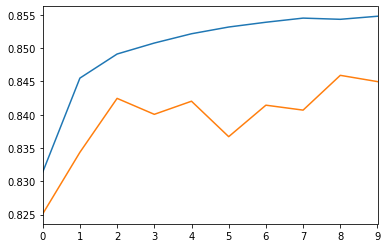

In [64]:
%matplotlib inline

df['ensemble_moyenne'].plot()
df['deepnet_moyenne'].plot()

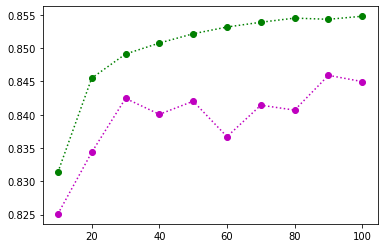

In [74]:
x_ensemble = []
y_ensemble = []
y_deepnet = []
y_ensemble_mean = []
y_deepnet_mean = []
i =0

for i in range(10):
    x = eval_christophe[0]
    y_ensemble = (eval_christophe[1][i] + eval_maxime[1][i] + eval_laurent[1][i] + eval_maud[1][i])/4
    y_deepnet = (eval_christophe[2][i] + eval_maxime[2][i] + eval_laurent[2][i] + eval_maud[2][i])/4
    y_ensemble_mean.append(y_ensemble)
    y_deepnet_mean.append(y_deepnet)
    
%matplotlib inline
plt.plot(x, y_ensemble_mean, ':go', x, y_deepnet_mean, ':mo')

In [ ]:
mean_lmcm = DataFrame({'y_ensemble_mean': y_ensemble_mean, 'y_deepnet_mean': y_deepnet_mean},
                      index = eval_maud[0])

mean_lmcm